# PBC Bigdata/ML ハンズオン
- S3上に配置したデータをAthenaを経由してSageMakerに取得する
- SageMaker上でデータの可視化やデータ加工を行う
- 広く利用されている機械学習ライブラリーである、Scikit-Learnを使ったモデル構築を試してみる
- 構築したモデルをSageMakerの推論Endpointとしてデプロイし、推論APIを構築する

# <font color="MediumSlateBlue">1. データを理解する</font>

In [2]:
!pip install awswrangler

    100% |████████████████████████████████| 71kB 27.7MB/s ta 0:00:01
    100% |████████████████████████████████| 20.2MB 2.4MB/s eta 0:00:01
    100% |████████████████████████████████| 10.1MB 6.1MB/s eta 0:00:01
    100% |████████████████████████████████| 62.9MB 788kB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 15.0MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 29.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for awswrangler ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/13/1a/52/966931a7453271ead15b0df3ea440e2f435d453cab8f6e99e3
Successfully built awswrangler
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2
  Found existing installation: s3fs 0.1.5
    Uninstalling s3fs-0.1.5:
      Successfully uninstalled s3fs-0.1.5
You are using pip versi

In [3]:
import awswrangler
import pandas as pd
import numpy as np

%matplotlib inline
pd.set_option('display.max_rows', 2000)

In [4]:
# Python上からAthenaを操作するために便利なライブラリー AWS Data Wranglerを利用する
session = awswrangler.Session()

# S3に格納されたjson_salesの件数を確認する
# この関数はPandas DataFrameを戻すが、表示させるだけの場合は変数に格納する必要はない
session.pandas.read_sql_athena(
    sql="select count(*) as json_sales_count from json_sales",
    database="workshop"
)

,json_sales_count
0,147287722


In [5]:
# 少量のデータを取得してJupyter上で見てみる
session.pandas.read_sql_athena(
    sql="select * from json_sales where prod_id is not null limit 5",
    database="workshop"
)

,prod_id,cust_id,time_id,channel_id,promo_id,quantity_sold,seller,fulfillment_center,courier_org,tax_country,tax_region,amount_sold
0,59,14809298,1995-01-01 00:00:00,4,348,31.0,10596,13036,1530,XJ,<NA>,48.0
1,128,12309724,1995-01-01 00:00:00,9,130,47.0,10903,14266,1087,GY,SW,79.0
2,112,5686925,1995-01-01 00:00:00,3,126,4.0,10575,14045,1535,YD,TG,82.0
3,117,12976874,1995-01-01 00:00:00,3,406,8.0,10770,13892,1041,GF,AZ,39.0
4,26,72065,1995-01-01 00:00:00,5,452,67.0,10294,13066,1053,XP,KF,60.0


In [6]:
# 後続処理で利用するデータは変数に格納する
# ここでは全期間のamaount_soldを日ごとに合計する処理をAthenaで行い、サマリーした結果をJupyter上で保持する
df_sales_daily = session.pandas.read_sql_athena(
    sql="select time_id, sum(amount_sold) as daily_sum from json_sales \
         where prod_id is not null \
         group by time_id order by time_id",
    database="workshop"
)
print('取得したデータの件数（日数）: {}'.format(df_sales_daily.shape[0]))

取得したデータの件数（日数）: 6919


In [7]:
df_sales_daily.head(5)

,time_id,daily_sum
0,1995-01-01 00:00:00,178490.0
1,1995-01-02 00:00:00,178516.0
2,1995-01-03 00:00:00,179277.0
3,1995-01-04 00:00:00,179204.0
4,1995-01-05 00:00:00,174441.0


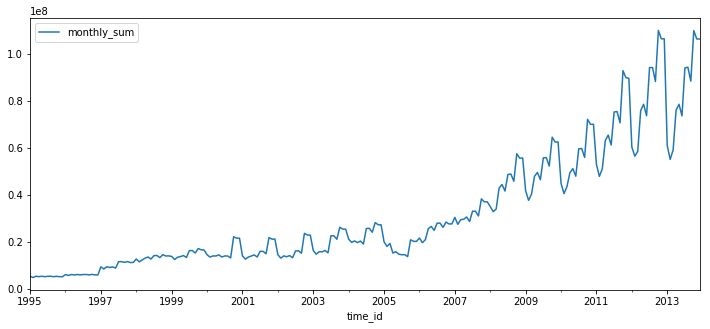

In [8]:
# 月単位の売り上げを集計してグラフ化する
df_sales_daily['time_id'] = pd.to_datetime(df_sales_daily.time_id)
df_sales_daily.set_index('time_id', inplace=True)
df_sales_monthly = df_sales_daily.resample('M').sum()

df_sales_monthly.rename(columns={'daily_sum':'monthly_sum'}, inplace=True)
df_sales_monthly.plot(figsize=(12,5))

#  <font color="MediumSlateBlue">2. データを加工する</font>

In [9]:
# 過去の実績値の推移を入力データにするため、1ヶ月前、2ヶ月前、3ヶ月前、12ヶ月前の実績値を取得する
df_data = df_sales_monthly['2007-01-01':].copy()
df_data['monthly_sum'] = df_data.monthly_sum / 1000000
df_data['1month_ago'] = df_data.monthly_sum.shift(1)
df_data['2month_ago'] = df_data.monthly_sum.shift(2)
df_data['3month_ago'] = df_data.monthly_sum.shift(3)
df_data['12month_ago'] = df_data.monthly_sum.shift(12)

# 過去のデータをシフトしているため、期間の開始から12レコード分は欠損値が発生する
df_data.head(20)

,monthly_sum,1month_ago,2month_ago,3month_ago,12month_ago
time_id,,,,,
2007-01-31,30.566316,NaN,NaN,NaN,NaN
2007-02-28,27.603369,30.566316,NaN,NaN,NaN
2007-03-31,29.601840,27.603369,30.566316,NaN,NaN
2007-04-30,29.738025,29.601840,27.603369,30.566316,NaN
2007-05-31,30.728862,29.738025,29.601840,27.603369,NaN
2007-06-30,28.790252,30.728862,29.738025,29.601840,NaN
2007-07-31,33.200844,28.790252,30.728862,29.738025,NaN
2007-08-31,33.164400,33.200844,28.790252,30.728862,NaN
2007-09-30,31.152977,33.164400,33.200844,28.790252,NaN


In [10]:
# 欠損値が発生した部分のデータは削除する
df_data = df_data['2008-01-01':].copy()
df_data.head(5)

,monthly_sum,1month_ago,2month_ago,3month_ago,12month_ago
time_id,,,,,
2008-01-31,35.147742,37.161129,37.171597,38.419859,30.566316
2008-02-29,32.977107,35.147742,37.161129,37.171597,27.603369
2008-03-31,34.076646,32.977107,35.147742,37.161129,29.601840
2008-04-30,43.029820,34.076646,32.977107,35.147742,29.738025
2008-05-31,44.545075,43.029820,34.076646,32.977107,30.728862


#  <font color="MediumSlateBlue">3. モデルを構築する</font>

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# モデルのトレーニングを行う鑵子を定義する
def train_lr_model(feature_cols, target_col, train_test_split):
    # 学習データとテストデータを分離
    train_x = df_data[:train_test_split][feature_cols].values
    train_y = df_data[:train_test_split][[target_col]].values
    train_index = df_data[:train_test_split].index
    test_x = df_data[train_test_split:][feature_cols].values
    test_y = df_data[train_test_split:][[target_col]].values
    test_index = df_data[train_test_split:].index

    # モデルのトレーニングを実行
    lr_model = LinearRegression(normalize=True)
    lr_model.fit(train_x, train_y)

    # テストデータに対して予測を実行
    test_pred = lr_model.predict(test_x)

    # 実績データと予測結果を結合して返却
    df_test = pd.DataFrame({'label': test_y[:,0], 
                            'pred': test_pred[:,0]}, index=test_index)
    df_train = pd.DataFrame({'label': train_y[:,0], 
                           }, index=train_index)
    df_result = pd.concat([df_train, df_test], sort=False).sort_index()

    return lr_model, df_test, df_result

# 1回目のモデル作成試行
feature_cols1 = ['1month_ago', '2month_ago', '3month_ago', '12month_ago']
target_col = 'monthly_sum'
train_test_split = '2011-12-31'

model1, df_test1, df_result1 = train_lr_model(feature_cols1, target_col, train_test_split)

r2 0.7618244363489933


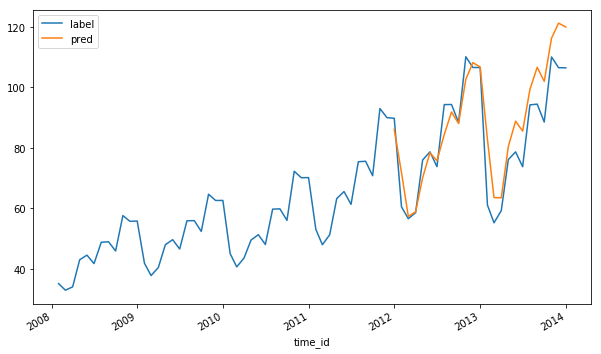

In [12]:
print('r2', r2_score(df_test1.label, df_test1.pred))
df_result1.plot(figsize=(10,6))

### モデル1の予測傾向
- r2乗値は約0.76となった
- 2012年の予測はある程度実績に追随している
- 2013年は、2012年までの増加傾向を反映して上振れした予測値となっている

#  <font color="MediumSlateBlue">3-2. モデルの改善を試みる</font>

In [13]:
# 年々増えていたり、月ごとに周期的な動きをしている傾向を取り込みたい
# そのために特徴量を追加する

df_data.reset_index(inplace=True)

df_data['month'] = df_data.time_id.dt.month
starting_year = df_data.time_id.dt.year.min()
df_data['year_delta'] = df_data.time_id.dt.year - starting_year
df_data.set_index('time_id', inplace=True)

In [14]:
# もう一度モデルの学習を実行
feature_cols2 = ['1month_ago', '2month_ago', '3month_ago', '12month_ago', 'month', 'year_delta']
model2, df_test2, df_result2 = train_lr_model(feature_cols2, target_col, train_test_split)

r2 0.847443065600014


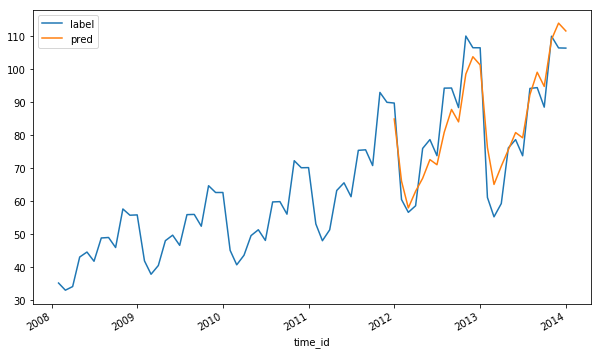

In [15]:
print('r2', r2_score(df_test2.label, df_test2.pred))
df_result2.plot(figsize=(10,6))

### モデル2の予測傾向
- r2乗値は約0.84に増加して、全体としての予実差は改善された
- 2013年の上振れ傾向は是正されているが、2012年がやや下振れした予測となった

In [16]:
# モデルはどんなパラメーターが算出されたのか
def WriteCoef(model, feature_cols):
    [print('coefficient[', v, ']=', model.coef_[0][i]) for i, v in enumerate(feature_cols)]
    print('intercept = ', model.intercept_)
    
print('model1:')
WriteCoef(model1, feature_cols1)
print()
print('model2:')
WriteCoef(model2, feature_cols2)

model1:
coefficient[ 1month_ago ]= 0.3592176685137094
coefficient[ 2month_ago ]= -0.01080780950346598
coefficient[ 3month_ago ]= -0.03741174129560228
coefficient[ 12month_ago ]= 0.7893041838986542
intercept =  [2.06498483]

model2:
coefficient[ 1month_ago ]= 0.22167201503077563
coefficient[ 2month_ago ]= -0.09740090013135928
coefficient[ 3month_ago ]= 0.15001683229497276
coefficient[ 12month_ago ]= 0.5114870600083773
coefficient[ month ]= 1.400423552419746
coefficient[ year_delta ]= 1.7269189894876196
intercept =  [5.52265153]


#  <font color="MediumSlateBlue">4. モデルを推論用に展開する</font>

In [17]:
import sagemaker
from sagemaker import get_execution_role

# Sagemaker session object
sagemaker_session = sagemaker.Session()

# Sagemakerの実行ロールを取得
role = get_execution_role()

In [18]:
# S3上のデータ出力先を定義
default_bucket = sagemaker_session.default_bucket()
s3_prefix = 'sagemaker-handson'
s3_path = 's3://{}/{}/monthly_sum'.format(default_bucket, s3_prefix)

# 事前に出力先のS3パスを掃除しておく
session.s3.delete_objects(path=s3_path)

out_cols = ['monthly_sum', '1month_ago', '2month_ago', '3month_ago', '12month_ago', 'month', 'year_delta']
df_train_estimator = df_data[:train_test_split][out_cols]
df_test_estimator = df_data[train_test_split:][out_cols]

# Jupyter上で処理していたデータをS3にdumpする
data_on_s3 = session.pandas.to_csv(dataframe=df_train_estimator, path=s3_path, preserve_index=False )
data_on_s3

['s3://sagemaker-us-east-1-497558320447/sagemaker-handson/monthly_sum/de867b6d46954df3b4b5be1d7e423824.csv',
 's3://sagemaker-us-east-1-497558320447/sagemaker-handson/monthly_sum/abec890f7b5b4cd189447a3e61fa308c.csv']

In [17]:
# S3上のデータ出力先を定義
default_bucket = sagemaker_session.default_bucket()
s3_prefix = 'sagemaker-handson'
s3_path = 's3://{}/{}/monthly_sum'.format(default_bucket, s3_prefix)

# 事前に出力先のS3パスを掃除しておく
session.s3.delete_objects(path=s3_path)

out_cols = ['monthly_sum', '1month_ago', '2month_ago', '3month_ago', '12month_ago', 'month', 'year_delta']
df_train_estimator = df_data[:train_test_split][out_cols]
df_test_estimator = df_data[train_test_split:][out_cols]

# Jupyter上で処理していたデータをS3にdumpする
data_on_s3 = session.pandas.to_csv(dataframe=df_data, path=s3_path, preserve_index=False )
data_on_s3

['s3://sagemaker-us-east-1-497558320447/sagemaker-handson/monthly_sum/e7265ac3a27d4002b380da7d60861534.csv',
 's3://sagemaker-us-east-1-497558320447/sagemaker-handson/monthly_sum/15b3c0a7d42c466d9e8b5d33bbdf1aca.csv',
 's3://sagemaker-us-east-1-497558320447/sagemaker-handson/monthly_sum/16d4c67f23454dbead82c1f43b581999.csv',
 's3://sagemaker-us-east-1-497558320447/sagemaker-handson/monthly_sum/b528df4f0b794ddeb127428c8da89077.csv']

In [19]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'sklearn_monthly_sum.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="local",
    role=role,
    hyperparameters={'normalize': True})

【参考】大量のデータを使用する重い学習に、学習用の別インスタンスを利用する場合は以下のように記述する
```python
from sagemaker.sklearn.estimator import SKLearn

script_path = 'sklearn_monthly_sum.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'normalize': True})
```

In [20]:
# S3に出力したデータを指定してモデルを学習させる
sklearn.fit({'train': s3_path})

Creating tmp4yqw_d62_algo-1-bkncl_1 ... 
Attaching to tmp4yqw_d62_algo-1-bkncl_12mdone
algo-1-bkncl_1  | 2020-02-19 07:42:51,457 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
algo-1-bkncl_1  | 2020-02-19 07:42:51,461 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-bkncl_1  | 2020-02-19 07:42:51,474 sagemaker_sklearn_container.training INFO     Invoking user training script.
algo-1-bkncl_1  | 2020-02-19 07:42:51,622 sagemaker-containers INFO     Module sklearn_monthly_sum does not provide a setup.py. 
algo-1-bkncl_1  | Generating setup.py
algo-1-bkncl_1  | 2020-02-19 07:42:51,623 sagemaker-containers INFO     Generating setup.cfg
algo-1-bkncl_1  | 2020-02-19 07:42:51,623 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-bkncl_1  | 2020-02-19 07:42:51,624 sagemaker-containers INFO     Installing module with the following command:
algo-1-bkncl_1  | /miniconda3/bin/python -m pip install . 
algo-1-bkncl_1 

===== Job Complete =====


In [21]:
# 学習が完了したので予測のためのpredictorを作成する
predictor = sklearn.deploy(initial_instance_count=1, instance_type="local")

Attaching to tmpam6zk9sj_algo-1-3046e_1
algo-1-3046e_1  | Processing /opt/ml/code
algo-1-3046e_1  | Building wheels for collected packages: sklearn-monthly-sum
algo-1-3046e_1  |   Building wheel for sklearn-monthly-sum (setup.py) ... done
algo-1-3046e_1  |   Created wheel for sklearn-monthly-sum: filename=sklearn_monthly_sum-1.0.0-py2.py3-none-any.whl size=7512 sha256=75dcc670be11ff49b93ce6c887d8989b1442327b62da9a7f4640f1c16cacfccf
algo-1-3046e_1  |   Stored in directory: /tmp/pip-ephem-wheel-cache-gf99aryt/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
algo-1-3046e_1  | Successfully built sklearn-monthly-sum
algo-1-3046e_1  | Installing collected packages: sklearn-monthly-sum
algo-1-3046e_1  | Successfully installed sklearn-monthly-sum-1.0.0
algo-1-3046e_1  | /miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation

【参考】実運用に利用するEndpointをdeployする際はインスタンスタイプの記述を変更する
```python
predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
```

#  <font color="MediumSlateBlue">5. endpointを使用してpredictionを行う</font>

In [22]:
df_test_estimator.head(10)

,monthly_sum,1month_ago,2month_ago,3month_ago,12month_ago,month,year_delta
time_id,,,,,,,
2011-12-31,89.727830,89.950106,92.951907,70.769899,70.150479,12,3
2012-01-31,60.468286,89.727830,89.950106,92.951907,53.064402,1,4
2012-02-29,56.589682,60.468286,89.727830,89.950106,47.980545,2,4
2012-03-31,58.577287,56.589682,60.468286,89.727830,51.282577,3,4
2012-04-30,75.967463,58.577287,56.589682,60.468286,63.211591,4,4
2012-05-31,78.652050,75.967463,58.577287,56.589682,65.541814,5,4
2012-06-30,73.758302,78.652050,75.967463,58.577287,61.327811,6,4
2012-07-31,94.252176,73.758302,78.652050,75.967463,75.388245,7,4
2012-08-31,94.285501,94.252176,73.758302,78.652050,75.548115,8,4


In [23]:
# Estimatorに合わせたテストデータを作成する
test_x = df_test_estimator.values[:,1:]
test_y = df_test_estimator.values[:,0]

In [24]:
pred = predictor.predict(test_x)
df_test_result = pd.DataFrame({'label':test_y, 'pred':pred})

algo-1-3046e_1  | 2020-02-19 07:44:05,734 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
algo-1-3046e_1  | /miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
algo-1-3046e_1  |   import imp
algo-1-3046e_1  | tuki code1: /opt/ml/model
algo-1-3046e_1  | 172.18.0.1 - - [19/Feb/2020:07:44:06 +0000] "POST /invocations HTTP/1.1" 200 328 "-" "-"


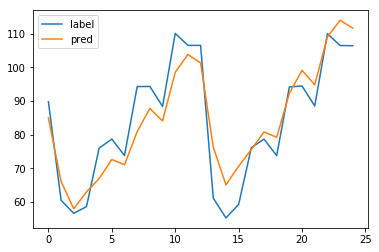

In [25]:
df_test_result.plot()